In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [39]:
CATEGORIES = ["top_10", "bottom_10", "top_10_aug", "top_10_aut"]
SEAS_START, SEAS_END = "2021-08-01", "2024-08-31"
PERIOD = 12     # monthly data

In [40]:
df = (
    pd.read_csv("data/output/time_series.csv")
    .query(f'date >= "{SEAS_START}"')
    .assign(date=lambda x: pd.to_datetime(x['date'], errors='coerce'))
    .sort_values("date")
)

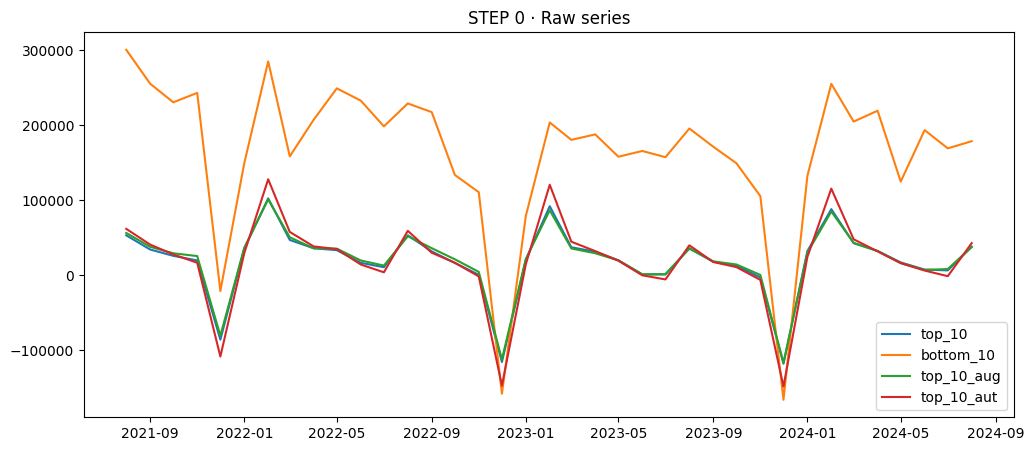

In [41]:
###############################################################
#########  1. BASIC PLOT:  raw normalized job flow series   ###
###############################################################

# Centers and normalizes the data according to the z-score for the category
plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    sub = df[df["cat"] == cat]
    plt.plot(sub["date"], sub["net_jobs"], label=cat)
plt.title("STEP 0 · Raw series")
plt.legend(); plt.show()

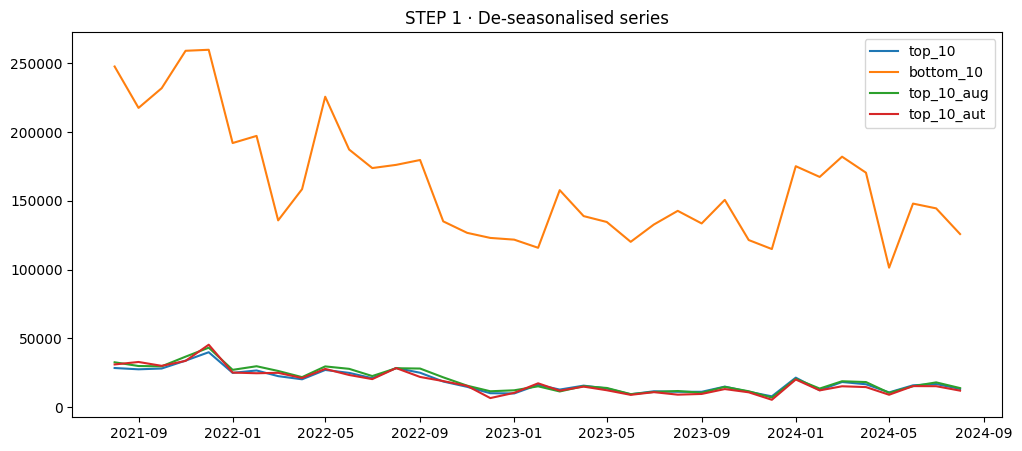

In [42]:
## 2. de-seasonalise via STL (monthly means) ####################3
seasonal_means = {}
for cat in CATEGORIES:
    series = (
                df
                .loc[
                      (df["cat"] == cat) & df["date"].between(SEAS_START, SEAS_END),
                      ["date", "net_jobs"]
                    ]
                .set_index("date")["net_jobs"]
                .asfreq("MS")
                .interpolate()
            )
    
    stl = STL(series, period=PERIOD).fit()
    
    seasonal_means[cat] = stl.seasonal.groupby(stl.seasonal.index.month).mean()

df["seasonal"] = df.apply(lambda r: seasonal_means[r["cat"]].loc[r["date"].month], axis=1)
df["net_jobs_dS"]   = df["net_jobs"] - df["seasonal"]

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS"], label=cat)
plt.title("STEP 1 · De-seasonalised series")
plt.legend(); plt.show()

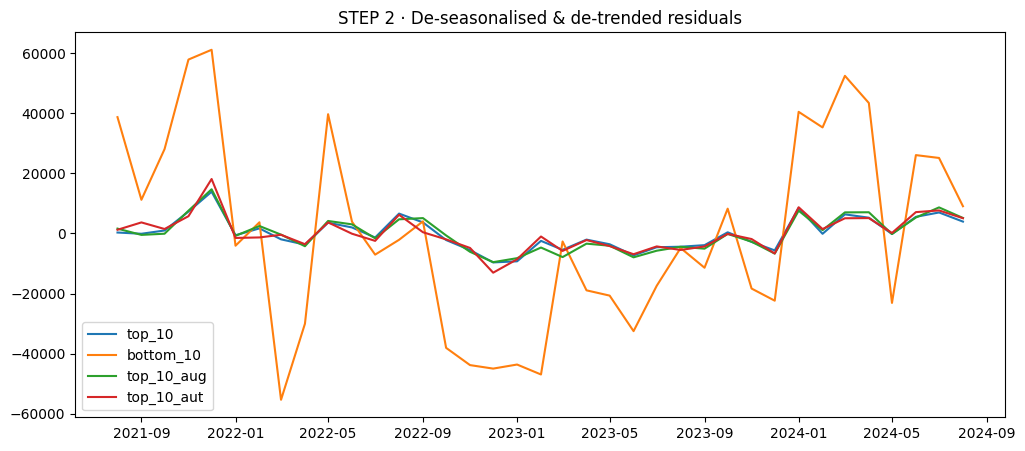

In [43]:
############ 3. remove constant / linear drift ###################################
df["t"] = (df["date"] - df["date"].min()).dt.days / 30   # months

lin_drift = {}

for cat in CATEGORIES:
    mask = df["cat"] == cat
    
    y = df.loc[mask, "net_jobs_dS"]
    X = sm.add_constant(df.loc[mask, ["t"]])

    ols = sm.OLS(y, X).fit()
    df.loc[mask, "net_jobs_dS_dT"] = y - ols.fittedvalues
    lin_drift[cat] = {"trend": ols}

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS_dT"], label=cat)
plt.title("STEP 2 · De-seasonalised & de-trended residuals")
plt.legend(); plt.show()

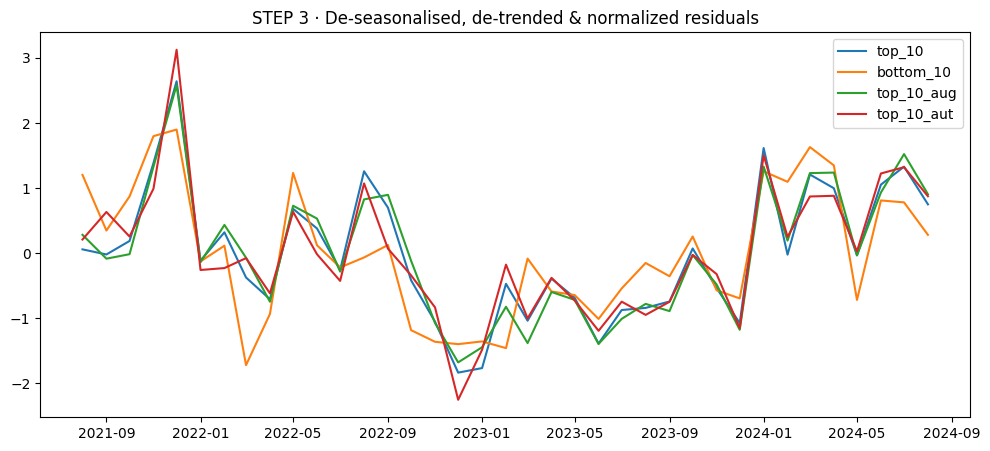

In [44]:
df = df.assign(
        net_jobs_dS_dT_norm=lambda x: (
                x["net_jobs_dS_dT"] - x.groupby("cat")["net_jobs_dS_dT"].transform("mean"))\
                / x.groupby("cat")["net_jobs_dS_dT"].transform("std")
            )

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "net_jobs_dS_dT_norm"], label=cat)
plt.title("STEP 3 · De-seasonalised, de-trended & normalized residuals")
plt.legend(); plt.show()

In [45]:
# ───── 4. fit AR(p) on residuals, choose p by AIC 1…6 ───────────────────
for cat in CATEGORIES:
    resid = (df.loc[df["cat"] == cat, ["date", "net_jobs_dS_dT_norm"]]
               .set_index("date")["net_jobs_dS_dT_norm"]
               .asfreq("MS"))          # give AutoReg a proper index

    best_aic, best_p, best_model = np.inf, None, None
    for p in range(1, 13):
        mod = AutoReg(resid, lags=p, old_names=False).fit()
        if mod.aic < best_aic:
            best_aic, best_p, best_model = mod.aic, p, mod

    p_adf = adfuller(resid.dropna())[1]
    print(f"{cat:<12} | ADF p={p_adf:.3f} | AR({best_p}) AIC={best_aic:.2f}")

    lin_drift[cat]["ar"] = best_model

top_10       | ADF p=0.518 | AR(12) AIC=68.05
bottom_10    | ADF p=0.013 | AR(12) AIC=73.01
top_10_aug   | ADF p=0.021 | AR(12) AIC=67.96
top_10_aut   | ADF p=0.774 | AR(12) AIC=65.65


In [46]:
# ───── 5. ARIMA(1,0,1) on residuals ───────────────────────────
for cat in CATEGORIES:
    resid = (df.loc[df['cat'] == cat, ['date', 'net_jobs_dS_dT_norm']]
               .set_index('date')['net_jobs_dS_dT_norm']
               .asfreq('MS'))
    arima = ARIMA(resid, order=(1,0,1)).fit()
    print(f'{cat:<12} | ARIMA(1,0,1) AIC={arima.aic:.2f}')
    lin_drift[cat]['arima'] = arima


top_10       | ARIMA(1,0,1) AIC=101.82
bottom_10    | ARIMA(1,0,1) AIC=99.76
top_10_aug   | ARIMA(1,0,1) AIC=99.12
top_10_aut   | ARIMA(1,0,1) AIC=103.28


In [47]:
# Make sure 'group' is categorical
df_ = (
    df
    .copy()
    [df['cat'].isin(['top_10_aug', 'bottom_10'])]
    .assign(cat = lambda x: x['cat'].astype('category'))
    .assign(month = lambda x: x['date'].asfreq('MS'))
)

# Fit the interaction model: value ~ time + group + time:group
model = sm.formula.ols("net_jobs_dS ~ month * cat", data=df_).fit(cov_type='HC1')

# Display full regression output
print(model.summary())

# Extract the slope difference coefficient and p-value
interaction_term = [col for col in model.params.index if 'month:cat' in col]
if interaction_term:
    slope_diff = model.params[interaction_term[0]]
    pval = model.pvalues[interaction_term[0]]
    print(f"\nSlope difference (interaction): {slope_diff:.4f}")
    print(f"P-value: {pval:.4g}")
else:
    print("Interaction term not found – check variable naming.")

                            OLS Regression Results                            
Dep. Variable:            net_jobs_dS   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     402.4
Date:                Sat, 31 May 2025   Prob (F-statistic):           3.38e-31
Time:                        10:34:57   Log-Likelihood:                -868.53
No. Observations:                  74   AIC:                             1741.
Df Residuals:                      72   BIC:                             1746.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.629e+05   6986.43

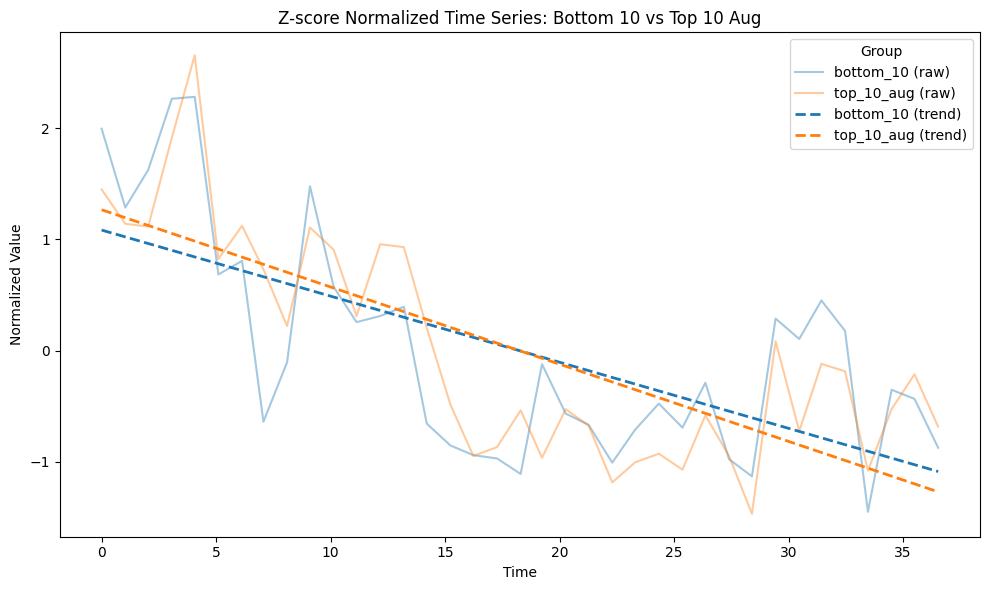

In [49]:
import statsmodels.api as sm

# Step 0: Filter and copy
df_norm = df[df['cat'].isin(['bottom_10', 'top_10_aug'])].copy()

# Step 1: Normalize within filtered groups only
df_norm['value_norm'] = df_norm.groupby('cat')['net_jobs_dS'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Step 2: Fit trend lines
trend_data = []
for name, group in df_norm.groupby('cat'):
    X = sm.add_constant(group['t'])
    y = group['value_norm']
    model = sm.OLS(y, X).fit()
    trend = model.predict(X)
    trend_data.append(pd.DataFrame({'t': group['t'], 'trend': trend, 'cat': name}))

trend_df = pd.concat(trend_data)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'bottom_10': 'tab:blue', 'top_10_aug': 'tab:orange'}

# Plot normalized series
for cat in df_norm['cat'].unique():
    subset = df_norm[df_norm['cat'] == cat]
    ax.plot(subset['t'], subset['value_norm'], label=f"{cat} (raw)", color=colors[cat], alpha=0.4)

# Plot trend lines
for cat in trend_df['cat'].unique():
    subset = trend_df[trend_df['cat'] == cat]
    ax.plot(subset['t'], subset['trend'], linestyle='--', label=f"{cat} (trend)", color=colors[cat], linewidth=2)

ax.set_title('Z-score Normalized Time Series: Bottom 10 vs Top 10 Aug')
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')
ax.legend(title='Group')
plt.tight_layout()
plt.show()
